In [1]:
!nvidia-smi

# **Preprocessing**
---


## Pipeline

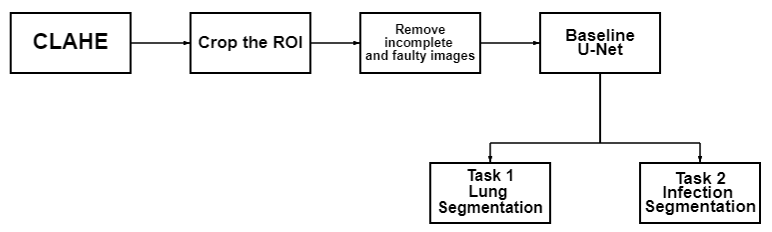

In [2]:
# Loading dependencies

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import pandas as pd
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import cv2
import copy
import catalyst
import wandb

from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout, Dropout2d, UpsamplingNearest2d
from albumentations import Compose,HorizontalFlip,VerticalFlip, Rotate
from albumentations.pytorch import ToTensor
from tqdm.autonotebook import tqdm, trange
from catalyst import dl
from catalyst.contrib.nn import DiceLoss, IoULoss, FocalLossBinary
from catalyst.dl.runner import SupervisedRunner
from torch.nn.functional import interpolate

In [3]:
seed = 271
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
wandb.login()

In [5]:
#20 CT-scans + (lung masks / infection masks / lungs + infections mask)

metadata = pd.read_csv('../input/covid19-ct-scans/metadata.csv')
print(metadata.shape)
metadata.head()

## **1) CLAHE**

In [7]:
img_size = 256
clahe = cv2.createCLAHE(clipLimit=3.0)


cts = nib.load(metadata.loc[0, 'ct_scan'])
slices = cts.shape[2]
print('Number of slices: ', slices)
    
arr = cts.get_fdata()
arr = np.rot90(np.array(arr))
arr = arr[:,:,range(80,200,20)]
arr = np.reshape(np.rollaxis(arr, 2),(arr.shape[2],arr.shape[0],arr.shape[1], 1))

fig, axes = plt.subplots(3, 6, figsize=(21,10))    

for i in range(arr.shape[0]):
    img = cv2.resize(arr[i], dsize=(img_size, img_size), interpolation=cv2.INTER_AREA)
    xmax, xmin = img.max(), img.min()
    img = (img - xmin)/(xmax - xmin)
    clahe_img = clahe_enhancer(img, clahe, list(axes[:, i]))

## **2) Crop the ROI**

In [9]:
cts = nib.load(metadata.loc[0, 'ct_scan'])
slices = cts.shape[2]
print('Number of slices: ', slices)
    
arr = cts.get_fdata()
arr = np.rot90(np.array(arr))
arr = arr[:,:,range(80,200,20)]
arr = np.reshape(np.rollaxis(arr, 2),(arr.shape[2],arr.shape[0],arr.shape[1], 1))

fig, axes = plt.subplots(3, 6, figsize=(18,9))    

for i in range(arr.shape[0]):
    img = cv2.resize(arr[i], dsize=(img_size, img_size), interpolation=cv2.INTER_AREA)
    xmax, xmin = img.max(), img.min()
    img = (img - xmin)/(xmax - xmin)
    _, bounds = crop_img(img, [])
    axes[0,i].imshow(img, cmap='bone')
    axes[0,i].set_title('Original CT')
    axes[0,i].set_xticks([]); axes[0,i].set_yticks([])
    
    clahe_img = clahe_enhancer(img, clahe, [])
    axes[1,i].imshow(clahe_img, cmap='bone')
    axes[1,i].set_title('Enhanced CT')
    axes[1,i].set_xticks([]); axes[1,i].set_yticks([])
    
    cropped_img = crop_(clahe_img, bounds)
    axes[2,i].imshow(cropped_img, cmap='bone')
    axes[2,i].set_title('Enhanced & cropped')
    axes[2,i].set_xticks([]); axes[2,i].set_yticks([])

In [10]:
cts = nib.load(metadata.loc[0, 'ct_scan'])
lungs = nib.load(metadata.loc[0, 'lung_mask'])
infec = nib.load(metadata.loc[0, 'infection_mask'])
slices = cts.shape[2]
    
arr_cts = cts.get_fdata()
arr_lungs = lungs.get_fdata()
arr_infec = infec.get_fdata()

arr_cts = np.rot90(np.array(arr_cts))
arr_lungs = np.rot90(np.array(arr_lungs))
arr_infec = np.rot90(np.array(arr_infec))

arr_cts = arr_cts[:, :, range(80,200,20)]
arr_lungs = arr_lungs[:, :, range(80,200,20)]
arr_infec = arr_infec[:, :, range(80,200,20)]

arr_cts = np.reshape(np.rollaxis(arr_cts, 2), 
                     (arr_cts.shape[2],arr_cts.shape[0],arr_cts.shape[1], 1))
arr_lungs = np.reshape(np.rollaxis(arr_lungs, 2), 
                     (arr_lungs.shape[2],arr_lungs.shape[0],arr_lungs.shape[1], 1))
arr_infec = np.reshape(np.rollaxis(arr_infec, 2), 
                     (arr_infec.shape[2],arr_infec.shape[0],arr_infec.shape[1], 1))

fig, axes = plt.subplots(3, 6, figsize=(18,6))    

for i in range(arr_cts.shape[0]):
    img_ct = cv2.resize(arr_cts[i], dsize=(img_size, img_size), interpolation=cv2.INTER_AREA)
    img_lungs = cv2.resize(arr_lungs[i], dsize=(img_size, img_size), interpolation=cv2.INTER_AREA)
    img_infec = cv2.resize(arr_infec[i], dsize=(img_size, img_size), interpolation=cv2.INTER_AREA)
    
    xmax, xmin = img_lungs.max(), img_lungs.min()
    img_lungs = (img_lungs - xmin)/(xmax - xmin)
    cropped_lungs, bounds = crop_img(img_lungs, [])
    
    xmax, xmin = img_ct.max(), img_ct.min()
    img_ct = (img_ct - xmin)/(xmax - xmin)
    clahe_ct = clahe_enhancer(img_ct, clahe, [])
    cropped_ct = crop_(clahe_ct, bounds)
    cropped_infec = crop_(img_infec, bounds)
    
    axes[0,i].imshow(cropped_ct, cmap='bone')
    axes[0,i].set_title("CT scan")
    axes[0,i].set_xticks([]); axes[0,i].set_yticks([])
    
    axes[1,i].imshow(cropped_lungs, cmap='bone')
    axes[1,i].set_title("Lungs mask")
    axes[1,i].set_xticks([]); axes[1,i].set_yticks([])

    axes[2,i].imshow(cropped_infec, cmap='bone')
    axes[2,i].set_title("Infection mask")
    axes[2,i].set_xticks([]); axes[2,i].set_yticks([])

In [11]:
cts_all = []
lungs_all = []
infects_all = []
max_w, max_h = 0, 0 #max width and height

for fnum in tqdm(range(20)) : #range(metadata.shape[0])) :
    cts = nib.load(metadata.loc[fnum, 'ct_scan'])
    lungs = nib.load(metadata.loc[fnum, 'lung_mask'])
    infec = nib.load(metadata.loc[fnum, 'infection_mask'])
    
    slices = cts.shape[2]

    arr_cts = cts.get_fdata()
    arr_lungs = lungs.get_fdata()
    arr_infec = infec.get_fdata()

    arr_cts = np.rot90(np.array(arr_cts))
    arr_lungs = np.rot90(np.array(arr_lungs))
    arr_infec = np.rot90(np.array(arr_infec))

    arr_cts = arr_cts[:, :, round(slices*0.2):round(slices*0.8)]
    arr_lungs = arr_lungs[:, :, round(slices*0.2):round(slices*0.8)]
    arr_infec = arr_infec[:, :, round(slices*0.2):round(slices*0.8)]

    arr_cts = np.reshape(np.rollaxis(arr_cts, 2), 
                     (arr_cts.shape[2],arr_cts.shape[0],arr_cts.shape[1], 1))
    arr_lungs = np.reshape(np.rollaxis(arr_lungs, 2), 
                     (arr_lungs.shape[2],arr_lungs.shape[0],arr_lungs.shape[1], 1))
    arr_infec = np.reshape(np.rollaxis(arr_infec, 2), 
                     (arr_infec.shape[2],arr_infec.shape[0],arr_infec.shape[1], 1))
    
    
    
    for i in range(arr_cts.shape[0]):
        img_lungs = cv2.resize(arr_lungs[i], dsize=(img_size, img_size), 
                              interpolation=cv2.INTER_AREA)
        xmax, xmin = img_lungs.max(), img_lungs.min()
        img_lungs = (img_lungs - xmin)/(xmax - xmin)
        cropped_lungs, bounds = crop_img(img_lungs, [])
        lungs_all.append(cropped_lungs)
        
        h, w = cropped_img.shape
        max_h, max_w = max(max_h, h), max(max_w, w)

        img_ct = cv2.resize(arr_cts[i], dsize=(img_size, img_size), 
                           interpolation=cv2.INTER_AREA)
        xmax, xmin = img_ct.max(), img_ct.min()
        img_ct = (img_ct - xmin)/(xmax - xmin)
        clahe_ct = clahe_enhancer(img_ct, clahe, [])
        cropped_ct = crop_(clahe_ct, bounds)
        cts_all.append(cropped_ct)

        img_infec = cv2.resize(arr_infec[i], dsize=(img_size, img_size), 
                              interpolation=cv2.INTER_AREA)
        cropped_infec = crop_(img_infec, bounds)
        infects_all.append(cropped_infec)

In [12]:
print(len(cts_all))

## **3) Removing incomplete and faulty images**

In [13]:
#Reshape each slice and delete faulty images

pix_size = 256

del_lst = []
for i in tqdm(range(len(cts_all))) :
    try :
        cts_all[i] = cv2.resize(cts_all[i], dsize=(pix_size, pix_size), interpolation=cv2.INTER_AREA)
        cts_all[i] = np.reshape(cts_all[i], (pix_size, pix_size, 1))

        lungs_all[i] = cv2.resize(lungs_all[i], dsize=(pix_size, pix_size), interpolation=cv2.INTER_AREA)
        lungs_all[i] = np.reshape(lungs_all[i], (pix_size, pix_size, 1))

        infects_all[i] = cv2.resize(infects_all[i], dsize=(pix_size, pix_size), interpolation=cv2.INTER_AREA)
        infects_all[i] = np.reshape(infects_all[i], (pix_size, pix_size, 1))
    except :
        del_lst.append(i)
            
    
for idx in del_lst[::-1] :
    del cts_all[idx]
    del lungs_all[idx]
    del infects_all[idx]

In [14]:
print(len(cts_all))

In [15]:
def check_empty(img):
    # Count white pixels
    sought = [1,1,1]
    white  = np.count_nonzero(img==sought)
    
    if white == 0:
        return(True)

In [16]:
# delete empty masks

del_lst = []
for i in tqdm(range(len(infects_all))) :
    if check_empty(infects_all[i]):
        del_lst.append(i)
            
    
for idx in del_lst[::-1] :
    del cts_all[idx]
    del lungs_all[idx]
    del infects_all[idx]

In [17]:
print(len(cts_all)) # len of correct slices

In [18]:
fig, axes = plt.subplots(1, 3, figsize=(9,3))

axes[0].imshow(cts_all[250][:, :, 0],cmap = 'bone')
axes[0].set_title("Enhanced & Cropped CT")

axes[1].imshow(lungs_all[250][:, :, 0], cmap='bone')
axes[1].set_title("Lungs")

axes[2].imshow(infects_all[250][:, :, 0], cmap='bone')
axes[2].set_title("Infection");


##  **Defining Covid19 CT Dataset** 

In [19]:
class Covid19_CT_Dataset(torch.utils.data.Dataset):
    
    def __init__(self, cts, masks, transforms=None):
        self.transforms = transforms
        self.cts = cts
        self.masks = masks
        self.len = len(cts)
        
    def __getitem__(self,index):
        

        image = self.cts[index]
        target_mask = self.masks[index]
           
        
        if self.transforms is not None:
            augment = self.transforms(image=image,mask=target_mask)
            image = augment['image']
            target_mask = augment['mask']


        target_mask = ToTensor()(image=target_mask)['image']
        
        image = ToTensor()(image=image)['image']
        
        result = {
            
            'image': image,
            'mask': target_mask
                 
        }
        
        return result
    
    
    def __len__(self):
        return self.len

## **Simple augmentations for train subset**

In [20]:
transforms = {
    'base': Compose([
                    HorizontalFlip(p=0.5),
                    VerticalFlip(p=0.2),
                    ]),    
}

In [21]:
dataset = Covid19_CT_Dataset(cts_all,lungs_all)

In [22]:
img_id = 100

fig, axes = plt.subplots(1, 2, figsize=(8,8)) 

axes[0].imshow(dataset[img_id]["image"].squeeze() , cmap = 'bone')
axes[0].set_title("Image")


axes[1].imshow(dataset[img_id]["mask"].squeeze() > 0 , cmap = 'bone')
axes[1].set_title("Ground Truth")


## **U-Net baseline**

In [23]:
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels , in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)


    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
    
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        
    def forward(self, x):
        return self.conv(x)


class UNet(nn.Module):
    """ Full assembly of the parts to form the complete network """
    def __init__(self, n_channels = 1, n_classes = 1, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)

        return logits

## **Defining subsets for Task 1 and Task 2** 

In [24]:
csv_file = r'../input/covid19-ct-scans/metadata.csv'
df = pd.read_csv(csv_file)
train_val_thresh = int(len(cts_all)*0.8)

cts_path = df['ct_scan'].tolist()
lungs_path = df['lung_mask'].tolist()
infects_path = df['infection_mask'].tolist()

train_cts = cts_all[:train_val_thresh]
train_lungs = lungs_all[:train_val_thresh]
train_infects = infects_all[:train_val_thresh]

val_cts = cts_all[train_val_thresh:]
val_lungs = lungs_all[train_val_thresh:]
val_infects = infects_all[train_val_thresh:]

In [25]:
lungs_train = Covid19_CT_Dataset(train_cts, train_lungs, transforms = transforms['base']) # for Task 1
lungs_val = Covid19_CT_Dataset(val_cts, val_lungs)

infects_train = Covid19_CT_Dataset(train_cts, train_infects, transforms = transforms['base']) # for Task 2
infects_val = Covid19_CT_Dataset(val_cts, val_infects)

In [26]:
lungs_train_loader = torch.utils.data.DataLoader(lungs_train, batch_size=32, shuffle=True, num_workers=2)
lungs_val_loader = torch.utils.data.DataLoader(lungs_val, batch_size=32, shuffle=False, num_workers=2)

infects_train_loader = torch.utils.data.DataLoader(infects_train, batch_size=32, shuffle=True, num_workers=2)
infects_val_loader = torch.utils.data.DataLoader(infects_val, batch_size=32, shuffle=False, num_workers=2)

## **Defining runner for training**

In [28]:
criterion = {
    "dice": DiceLoss(),
    "iou": IoULoss(),
    "bce": nn.BCEWithLogitsLoss()
}

callbacks = [
    dl.CriterionCallback(
        input_key="mask", prefix="loss_dice", criterion_key="dice"
    ),
    dl.CriterionCallback(
        input_key="mask", prefix="loss_iou", criterion_key="iou"
    ),
    dl.CriterionCallback(
        input_key="mask", prefix="loss_bce", criterion_key="bce"
    ),
    dl.MetricAggregationCallback(
        prefix="loss",
        mode="weighted_sum",
        metrics={"loss_dice": 1.0, "loss_iou": 1.0, "loss_bce": 1.0},
    ),
    dl.DiceCallback(input_key="mask"),
    dl.IouCallback(input_key="mask"),
    dl.callbacks.WandbLogger(
            project="lungs_infs_segmentation"
        )
]


# **Task 1 (Lungs Segmentations)**
---

In [29]:
lungs_model = UNet().to(device)

In [30]:
lungs_runner = SupervisedRunner(input_key="image", input_target_key="mask", device=device)

optimizer = torch.optim.Adam(lungs_model.parameters(), lr=1e-3)

scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0 = 10, eta_min = 1e-6)

lungs_loaders = {
    "train": lungs_train_loader,
    "valid": lungs_val_loader,
}


In [31]:
lungs_runner.train(
    model = lungs_model,
    criterion = criterion,
    optimizer = optimizer,
    scheduler = scheduler,
    loaders = lungs_loaders,
    callbacks = callbacks,
    num_epochs = 30,
    main_metric = "dice", 
    minimize_metric = False,
    verbose = True,
    
)

## **Checking model inference**

In [32]:
visualize_mask(lungs_model, lungs_val)

# **Task 2 (Infection Segmentation)**
---

In [33]:
torch.cuda.empty_cache()

In [34]:
infects_model = UNet().to(device)

In [35]:
infects_runner = SupervisedRunner(input_key="image", input_target_key="mask", device=device)

optimizer = torch.optim.Adam(infects_model.parameters(), lr=1e-3)

scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0 = 10, eta_min = 1e-6)

infects_loaders = {
    "train": infects_train_loader,
    "valid": infects_val_loader,
}

In [36]:
infects_runner.train(
    model = infects_model,
    criterion = criterion,
    optimizer = optimizer,
    scheduler = scheduler,
    loaders = infects_loaders,
    callbacks = callbacks,
    num_epochs = 30,
    main_metric = "dice", 
    minimize_metric = False,
    verbose = True,
)

## **Checking model inference**

In [57]:
visualize_mask(infects_model, infects_val, threshold = True, threshold_value = 0.9)

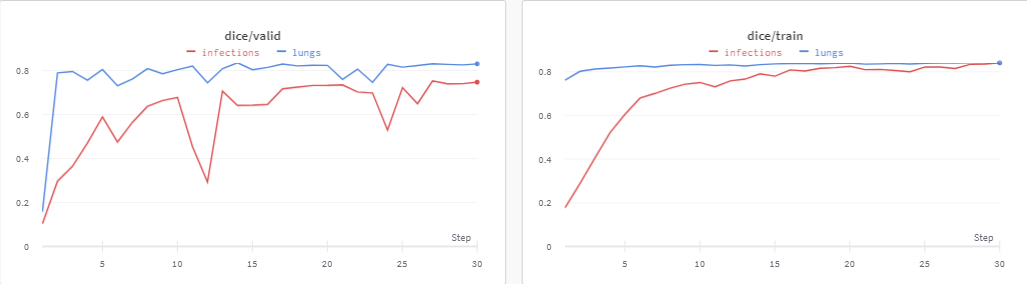

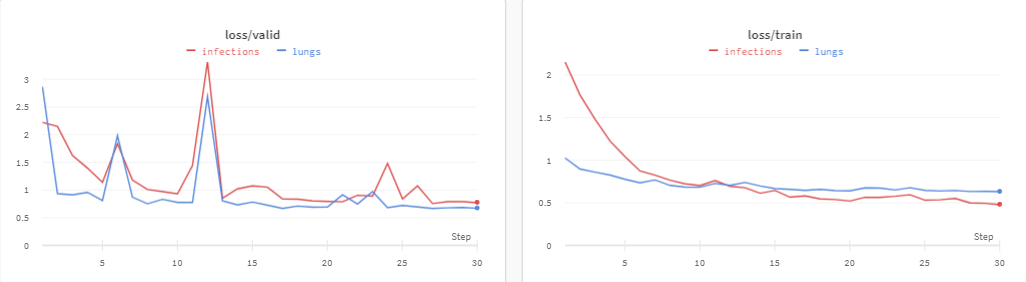